# DMPR Exercise 3: The Machine Learning Workflow
### Lecturer: Dr. Gjergji Kasneci

###Topics:
- Preprocessing the data: Feature selection
- Training & Evaluating a Model
  - Decision Trees
  - Imbalances
  - Evaluation Metrics

Datasets: Arcene and Credit

In [ ]:
# Load packages and datasets
import numpy as np
import pandas as pd
from timeit import default_timer as timer

np.random.seed(0)

arcene_link = 'https://www.dropbox.com/s/qhwr89qvfaetdjj/arcene.csv?dl=1'
credit_link = 'https://www.dropbox.com/s/107j029gd4zxswq/creditcard_tu_edition.csv?dl=1'

# Data Preprocessing - Feature Selection

Let's start with an example: The **ARCENE** data set distinguishes cancer and normal patterns from mass-spectrometric data (binary classification). ARCENE is one of 5 datasets of the NIPS 2003 feature selection challenge. 

We already normalized the dataset (MinMaxScaler() to range [0,1])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

In [ ]:
arcene = pd.read_csv(arcene_link)
arcene.head()

,target,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9961,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
0,1.0,0.000000,0.325688,0.000000,0.134752,0.000000,0.786344,0.806387,0.27027,0.000000,0.000000,0.0,0.0,0.077273,0.000000,0.339853,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.234375,0.000000,0.275542,0.472072,0.0,0.426087,0.567164,0.000000,0.0,0.334416,0.063545,0.043689,0.015625,0.0,0.0,0.00,0.000000,...,0.0,0.669927,0.0,0.000000,0.082251,0.000000,0.511041,0.282723,0.058974,0.000000,0.000000,0.0,0.819957,0.0,0.000000,0.000000,0.0,0.0,0.265306,0.000000,0.500000,0.434109,0.0,0.0,0.000000,0.497758,0.000,0.000000,0.000000,0.000000,0.213656,0.823699,0.430,0.000000,0.054878,0.000000,0.189125,0.0,0.000000,0.983114
1,0.0,0.000000,0.188073,0.341667,0.234043,0.550459,0.821586,0.756487,0.00000,0.351485,0.000000,0.0,0.0,0.000000,0.419753,0.645477,0.000000,0.0,0.0,0.001560,0.024476,0.0,0.0,0.000000,0.000000,0.340557,0.473874,0.0,0.521739,0.940299,0.000000,0.0,0.451299,0.000000,0.218447,0.000000,0.0,0.0,0.00,0.034921,...,0.0,0.611247,0.0,0.127072,0.000000,0.096677,0.059937,0.502618,0.010256,0.416667,0.000000,0.0,0.891540,0.0,0.000000,0.000000,0.0,0.0,0.535714,0.142857,0.544218,0.550388,0.0,0.0,0.217105,0.544843,0.000,0.241379,0.366279,0.175439,0.167401,0.874277,0.345,0.077778,0.721037,0.000000,0.134752,0.0,0.578411,0.793621
2,1.0,0.000000,0.000000,0.004167,0.056738,0.000000,0.594714,0.802395,0.00000,0.000000,0.000000,0.0,0.0,0.068182,0.000000,0.413203,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.109375,0.000000,0.374613,0.500901,0.0,0.573913,0.791045,0.000000,0.0,0.334416,0.010033,0.038835,0.000000,0.0,0.0,0.00,0.000000,...,0.0,0.723716,0.0,0.000000,0.004329,0.015106,0.000000,0.120419,0.000000,0.000000,0.000000,0.0,0.887202,0.0,0.000000,0.000000,0.0,0.0,0.346939,0.000000,0.581633,0.405685,0.0,0.0,0.042763,0.549327,0.000,0.053640,0.005814,0.000000,0.191630,0.856936,0.140,0.000000,0.036585,0.000000,0.212766,0.0,0.069246,0.953096
3,1.0,0.000000,0.256881,0.183333,0.390071,0.128440,0.726872,0.938124,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.851852,0.415648,0.000000,0.0,0.0,0.085803,0.000000,0.0,0.0,0.265625,0.000000,0.684211,0.466667,0.0,0.388406,0.665245,0.000000,0.0,0.214286,0.093645,0.000000,0.234375,0.0,0.0,0.00,0.041270,...,0.0,0.520782,0.0,0.000000,0.000000,0.072508,0.170347,0.062827,0.000000,0.000000,0.000000,0.0,0.774403,0.0,0.000000,0.000000,0.0,0.0,0.295918,0.000000,0.588435,0.377261,0.0,0.0,0.000000,0.531390,0.000,0.099617,0.151163,0.105263,0.033040,0.867052,0.000,0.288889,0.131098,0.000000,0.241135,0.0,0.000000,0.879925
4,0.0,0.541237,0.000000,0.587500,0.493617,0.000000,0.191630,0.656687,0.00000,0.000000,0.002353,0.0,0.0,0.104545,0.000000,0.518337,0.053292,0.0,0.0,0.502340,0.000000,0.0,0.0,0.000000,0.009662,0.820433,0.230631,0.0,0.249275,0.650320,0.161725,0.0,0.649351,0.000000,0.165049,0.000000,0.0,0.0,0.08,0.000000,...,0.0,0.244499,0.0,0.176796,0.290043,0.000000,0.000000,0.434555,0.000000,0.000000,0.023451,0.0,0.555315,0.0,0.143898,0.373494,0.0,0.0,0.147959,0.000000,0.120748,0.325581,0.0,0.0,0.789474,0.300448,0.224,0.003831,0.000000,0.000000,0.828194,0.000000,0.000,0.000000,0.000000,0.373281,0.711584,0.0,0.000000,0.664165


In [ ]:
# Split in Train and Test set
y = arcene['target'].to_numpy()
X = arcene.drop('target', axis=1).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Let's classify cancerous from normal patterns!

We use a the **K-Nearest-Neighbor** classifier. As the name would suggest, KNN classifies a new instance based on its K nearest neighbors. KNN is a **'lazy' classifier**, why?

![KNN](https://www.researchgate.net/profile/Saleh_Alaliyat/publication/267953942/figure/fig14/AS:295388776026147@1447437580523/K-nearest-neighbor-algorithm-illustration-The-green-circle-is-the-sample-which-is-to-be.png)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
train_start = timer()
knn.fit(X_train, y_train)
train_time = timer() - train_start
y_pred = knn.predict(X_test)
print('Accuracy (Test Set) = {}'.format(round(accuracy_score(y_test, y_pred), 2)))
print('Training Time = {}ms'.format(round(train_time, 5)))

Accuracy (Test Set) = 0.79
Training Time = 0.02942ms


Not to bad! However, let's look at the training error...

In [ ]:
y_pred = knn.predict(X_train)
print('Accuracy (Training Set) = {}'.format(round(accuracy_score(y_train, y_pred), 2)))

Accuracy (Training Set) = 0.92


Is there a way to decrease the difference between training and testing accuracy? What causes the effect above? Let's look at the data...

In [ ]:
arcene.describe()

,target,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,9961,9962,9963,9964,9965,9966,9967,9968,9969,9970,9971,9972,9973,9974,9975,9976,9977,9978,9979,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999,10000
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,...,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.440000,0.182397,0.169977,0.251271,0.461596,0.156468,0.506476,0.451717,0.103986,0.241559,0.166506,0.142193,0.039918,0.136455,0.034568,0.548741,0.190611,0.106346,0.006417,0.333432,0.034248,0.057147,0.087331,0.107031,0.161908,0.289118,0.483468,0.116351,0.310986,0.668667,0.242857,0.122680,0.314789,0.192492,0.191165,0.215586,0.164200,0.036944,0.035100,0.112397,...,0.036641,0.436944,0.010000,0.283204,0.139437,0.179094,0.089968,0.149738,0.011590,0.123333,0.084389,0.071429,0.489349,0.154538,0.226803,0.080321,0.034038,0.128676,0.274235,0.179173,0.278435,0.300879,0.157123,0.033958,0.411546,0.352657,0.208472,0.185134,0.035320,0.168333,0.347379,0.553981,0.230750,0.205278,0.163369,0.349450,0.478026,0.028750,0.179155,0.678518
std,0.497633,0.251318,0.174105,0.296535,0.220099,0.248579,0.232778,0.362343,0.201266,0.287945,0.227620,0.211646,0.154621,0.204900,0.126490,0.197684,0.235228,0.226985,0.071490,0.238109,0.121847,0.140595,0.169244,0.186759,0.216986,0.259943,0.213451,0.227239,0.228893,0.159571,0.250460,0.199156,0.269254,0.274164,0.244456,0.282786,0.274445,0.108975,0.138528,0.124255,...,0.121880,0.203539,0.088875,0.249600,0.214279,0.220540,0.151697,0.203062,0.080492,0.191669,0.138528,0.167776,0.356843,0.227085,0.259102,0.167211,0.137419,0.205646,0.188582,0.253238,0.241154,0.257732,0.274773,0.095923,0.325267,0.304080,0.203322,0.187877,0.134021,0.239890,0.295516,0.339574,0.244743,0.277569,0.240549,0.280198,0.279963,0.140316,0.227039,0.196942
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.003440,0.000000,0.300000,0.000000,0.287996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.402812,0.000000,0.000000,0.000000,0.130655,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.277477,0.000000,0.000000,0.603412,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025397,...,0.000000,0.270782,0.000000,0.052947,0.000000,0.000000,0.000000,0.003927,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.131378,0.000000,0.000000,0.000000,0.000000,0.000000,0.133224,0.000000,0.

In [ ]:
arcene.shape

(200, 10001)

Here #features >> #instances. **Are all these features relevant?** Remember that ARCENE contains spectral measurements. We would expect to see relevant effects in only some of the signal dimensions.

In fact, we generally observe that only a subset of features is relevant for learning. Some features might be redundant, some might just be random noise. Moreover, high-dimensional data can lead to the overfitting of our predictive model. Especially, if #features >> #instances -> **Curse of dimensionality**

**Feature selection** is a well-explored dimensionality reduction method. The goal of feature selection is to **select a subset of discriminatory features** that yield accurate predictions and a more interpretable model. Feature selection can also help to speed up training.

As an example, we take a look at three simple feature selection techniques:


1.   Feature selection based on variance (remove all features with a variance beneath a specified threshold)
2.   Feature selection based on mutual information MI (measure dependence between every feature and the target; select feature with highest MI score)
3.   Sequential feature selection (sequentially add relevant or remove noisy features)





In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE
from sklearn.tree import DecisionTreeClassifier
m = 2000  # number of selected features

### Feature Selection based on Variance

In [ ]:
start_fs = timer()
var = np.var(X_train, axis=0)
var_sort = np.argsort(var)[::-1]  # sort in descending order

# Select features
X_train_var = X_train[:, var_sort[:m]] 
X_test_var = X_test[:, var_sort[:m]] 
fs_time = timer() - start_fs

# Run training with reduced feature set
train_start = timer()
knn.fit(X_train_var, y_train)
train_time = timer() - train_start

y_pred_test = knn.predict(X_test_var)
y_pred_train = knn.predict(X_train_var)

print('Accuracy (Test Set) = {}'.format(round(accuracy_score(y_test, y_pred_test), 2)))
print('Accuracy (Training Set) = {}'.format(round(accuracy_score(y_train, y_pred_train), 2)))
print('Training + FS Time = {}ms'.format(round(train_time + fs_time, 5)))

Accuracy (Test Set) = 0.74
Accuracy (Training Set) = 0.9
Training + FS Time = 0.02934ms


### Feature Selection based on Mutual Information

![MI](https://wikimedia.org/api/rest_v1/media/math/render/svg/4b37af4015d70867b9c50b9cf82e0fc3598b070c)

MI quantifies the amount of shared bits between random variables. It is a measure of mutual dependence. Why does it make sense to use MI/ When does MI evaluate to 0?

In [ ]:
start_fs = timer()
selection = SelectKBest(mutual_info_classif, k=m)
selection.fit(X_train, y_train)

# Select features
X_train_mi = selection.transform(X_train)
X_test_mi = selection.transform(X_test)
fs_time = timer() - start_fs

# Run training with reduced feature set
train_start = timer()
knn.fit(X_train_mi, y_train)
train_time = timer() - train_start

y_pred_test = knn.predict(X_test_mi)
y_pred_train = knn.predict(X_train_mi)

print('Accuracy (Test Set) = {}'.format(round(accuracy_score(y_test, y_pred_test), 2)))
print('Accuracy (Training Set) = {}'.format(round(accuracy_score(y_train, y_pred_train), 2)))
print('Training + FS Time = {}ms'.format(round(train_time + fs_time, 5)))

Accuracy (Test Set) = 0.79
Accuracy (Training Set) = 0.9
Training + FS Time = 24.91519ms


### Sequential Feature Selection

In [ ]:
start_fs = timer()
fs_estimator = DecisionTreeClassifier(max_depth=5, random_state=0)  # estimator that yields a feature importance score
selection = RFE(estimator=fs_estimator, n_features_to_select=m, step=10)  # RFE-> Recursive Feature Elimination
selection.fit(X_train, y_train)

# Select features
X_train_seq = selection.transform(X_train)
X_test_seq = selection.transform(X_test)
fs_time = timer() - start_fs

# Run training with reduced feature set
train_start = timer()
knn.fit(X_train_seq, y_train)
train_time = timer() - train_start

y_pred_test = knn.predict(X_test_seq)
y_pred_train = knn.predict(X_train_seq)

print('Accuracy (Test Set) = {}'.format(round(accuracy_score(y_test, y_pred_test), 2)))
print('Accuracy (Training Set) = {}'.format(round(accuracy_score(y_train, y_pred_train), 2)))
print('Training + FS Time = {}ms'.format(round(train_time + fs_time, 5)))

Accuracy (Test Set) = 0.85
Accuracy (Training Set) = 0.89
Training + FS Time = 131.9074ms


### Take Aways


*   Feature Selection is not trivial.
*   Feature Selection reduces the number of features and can thus mitigate the effect of overfitting models. This in turn leads to models that generalize better and are more interpretable
*   There are trade-offs between efficiency and predictive power
*   We only showed three very simple feature selection algorithms. There are much more complex and better-performing feature selection algorithms available. A good introduction to feature selection is given in: `Guyon, Isabelle, and André Elisseeff. "An introduction to variable and feature selection." Journal of machine learning research 3.Mar (2003): 1157-1182.`


*   At DSAR we work on explainable models, including online feature selection -> if you are interested in doing a **Master's theses**, check our current openings or contact us

## **--- 5 Min Break ---**



# Training & Evaluating a Model

When training a predictive model, we need to split our data into distinct sets:
* Training set: used to train the model
* Test set: used to evaluate the final model
* (Validation set: used for hyperparameter tuning)

We can choose among different validation methods:
* **Holdout Validation**: Randomly select a fraction of the original data as test set and keep the remaining samples as training set. We evaluate the model based on the test set.
* **K-fold Cross Validation**: First, we randomly partition our data into K distinct and equally sized folds. Iteratively, we select every fold once for testing and leave the remaining samples for training. In each of the K iterations we can compute an evaluation measure (e.g. accuracy). We average all K measurements for the final result.

![CV](https://sebastianraschka.com/images/faq/evaluate-a-model/k-fold.png)

Sometimes we want to maintain the original class proportions during training. In these cases we can use **stratified K-Fold Cross Validation**. Stratification seeks to ensure that each fold is representative of the data.

![stratified CV](https://i.stack.imgur.com/XJZve.png)

In general, K-fold Cross Validation yields more robust evaluations than Holdout Validation.

As an example, we train a KNN classifier with 10-fold Cross Validation on a stratified sample of the [Credit Card Fraud Detection data](https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets/data) set. The dataset contains transactions made by credit cards in September 2013 by european cardholders. It contains only numerical input variables which are the result of a PCA transformation. It is a binary classification between fraudulent and genuine transactions.


In [ ]:
from sklearn.model_selection import KFold

# Import data set
credit = pd.read_csv(credit_link)
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,131858.0,2.121170,-1.728822,-0.942772,-1.845503,-0.754363,1.194050,-1.632006,0.433245,-1.124254,1.610453,0.590807,-0.511058,-0.455080,-0.122746,0.136577,-0.890342,0.840868,-0.523066,-0.759240,-0.527289,-0.053718,0.375947,0.250680,-1.674808,-0.479686,-0.062797,0.063124,-0.070915,31.00,0
1,119312.0,1.918177,-0.264101,-0.802759,0.954060,0.196860,0.539304,-0.374121,0.130114,0.628510,0.303477,-0.357299,0.854292,0.596020,0.077401,-0.222130,0.921425,-1.413292,0.685061,0.367871,-0.086287,-0.222134,-0.635082,0.162029,-1.453850,-0.236885,-0.921645,0.041567,-0.040207,52.45,0
2,44916.0,0.373120,-0.793431,-0.032320,1.834408,-0.742549,-0.391450,0.306981,-0.037983,0.031510,-0.694461,1.721925,0.971879,0.135551,-1.330202,-0.184766,0.711236,0.687364,1.010276,-0.446477,0.710211,0.201942,-0.157752,-0.413267,0.434715,0.367752,-0.408637,-0.011377,0.122522,393.53,0
3,14469.0,1.101430,-0.162202,0.927627,0.227623,-0.708281,-0.153691,-0.578088,0.059882,1.448840,-0.407836,2.753506,-1.497222,1.704653,1.707450,0.113262,0.331903,0.394276,0.133207,-0.557004,-0.058361,0.040865,0.326155,0.005728,0.243643,0.069822,1.028265,-0.080475,-0.001598,39.00,0
4,34325.0,0.830859,-0.453534,1.068828,1.525193,-1.019679,-0.168972,-0.256172,-0.036818,0.536988,-0.191853,-0.534990,0.896022,1.178658,-0.432225,0.489033,0.259045,-0.478132,0.109426,-0.546261,0.288851,0.241025,0.525052,-0.255012,0.446590,0.478389,-0.264575,0.041714,0.068586,180.00,0


In [ ]:
credit.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000,10191.000000
mean,93667.063684,-0.163298,0.069929,-0.167188,0.117804,-0.093725,-0.039948,-0.145566,0.036577,-0.026115,-0.130228,0.078225,-0.132992,0.003500,-0.129747,-0.007748,-0.080372,-0.161700,-0.055762,0.019373,0.006515,0.013829,-0.002930,-0.003892,-0.014928,0.004443,0.001637,0.013581,0.007470,90.134812,0.019625
std,47758.486924,2.474295,1.931748,2.206104,1.623465,1.766671,1.369568,1.797993,1.527775,1.220358,1.526281,1.260762,1.550547,1.001868,1.552458,0.922791,1.231968,1.761821,1.018107,0.840666,0.851903,0.831089,0.732107,0.623567,0.611315,0.543130,0.476839,0.437562,0.438814,231.278941,0.138715
min,1.000000,-32.353040,-32.494845,-31.103685,-4.852956,-22.105532,-17.282140,-21.922811,-26.717453,-9.283925,-18.271168,-4.797473,-17.769143,-3.547958,-19.214325,-3.332690,-13.563273,-25.162799,-9.498746,-3.906932,-25.222345,-14.017988,-5.645854,-19.254328,-2.775670,-4.781606,-1.359715,-6.765834,-6.172259,0.000000,0.000000
25%,52768.000000,-0.980004,-0.592631,-0.950934,-0.816297,-0.724585,-0.792306,-0.601153,-0.214294,-0.656964,-0.583939,-0.757924,-0.462853,-0.651164,-0.452216,-0.591213,-0.492070,-0.502664,-0.528485,-0.451912,-0.212566,-0.229637,-0.557195,-0.168961,-0.368014,-0.323346,-0.320385,-0.069243,-0.051700,5.550000,0.000000
50%,84109.000000,-0.010816,0.077455,0.147902,0.024786,-0.076187,-0.275635,0.023342,0.030589,-0.043352,-0.113065,-0.001621,0.133574,-0.006028,0.034555,0.028339,0.062903,-0.069766,-0.011366,0.015904,-0.057561,-0.021950,0.009468,-0.009923,0.033414,0.024649,-0.049204,0.004157,0.012022,21.810000,0.000000
75%,138252.000000,1.296899,0.860336,0.991285,0.815584,0.608168,0.407755,0.559645,0.347613,0.622945,0.421860,0.772006,0.616417,0.677368,0.499977,0.649074,0.534458,0.397656,0.497009,0.476226,0.149955,0.200114,0.543460,0.147559,0.428738,0.357444,0.243724,0.100718,0.083290,80.475000,0.000000
max,172780.000000,2.390655,16.713389,3.924953,12.132323,28.516513,13.348714,23.475217,20.007208,7.871113,12.424602,12.018913,4.233714,3.673476,7.439566,3.898971,4.870361,6.739384,3.579932,5.228342,11.966949,19.325063,4.143681,15.626067,3.962197,5.541598,2.917823,9.879903,15.522649,5356.420000,1.000000


In [ ]:
credit.shape

(10191, 31)

We observe that **#features << #instances**. Hence, dimensionality reduction/feature selection should not be necessary. Moreover, we will use a Random Forest classifier, so normalization is not necessary.

A **Random Forest (RF)** is an ensemble of simple decision trees. RF applies **Bagging** (Bootstrap aggregation): Bagging repeatedly (B times) selects a random sample with replacement of the training set and fits trees to these samples. At each candidate split in the learning process, RF selects a random subset of the features. **Why doesn't RF just allow to select among all features at every split?**
![Random Forest](https://i.stack.imgur.com/iY55n.jpg)

Finally, RF aggregates the predictions of all Decision Trees in the ensemble for a final prediction.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

y = credit['Class'].to_numpy()
X = credit.drop('Class', axis=1).to_numpy()

In [ ]:
k=10

kf = KFold(n_splits=k, shuffle=True, random_state=42)
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_probs = dict()
roc_true = dict()

rf = RandomForestClassifier(n_estimators=50, max_depth=3, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X)):  # for every fold
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  rf.fit(X_train, y_train)
  y_pred = rf.predict(X_test)
  
  # For ROC curve
  roc_probs[fold] = rf.predict_proba(X_test)  # probabilities
  roc_true[fold] = y_test

  accuracies.append(accuracy_score(y_test, y_pred))
  precisions.append(precision_score(y_test, y_pred))
  recalls.append(recall_score(y_test, y_pred))
  f1_scores.append(f1_score(y_test, y_pred))

### Evaluation Metrics
From the lecture we already know:
* Recall
* Precision
* Accuracy
* F1 (Harmonic Mean between Precision and Recall)
* Receiver Operating Characteristic (ROC)

So let's apply these...

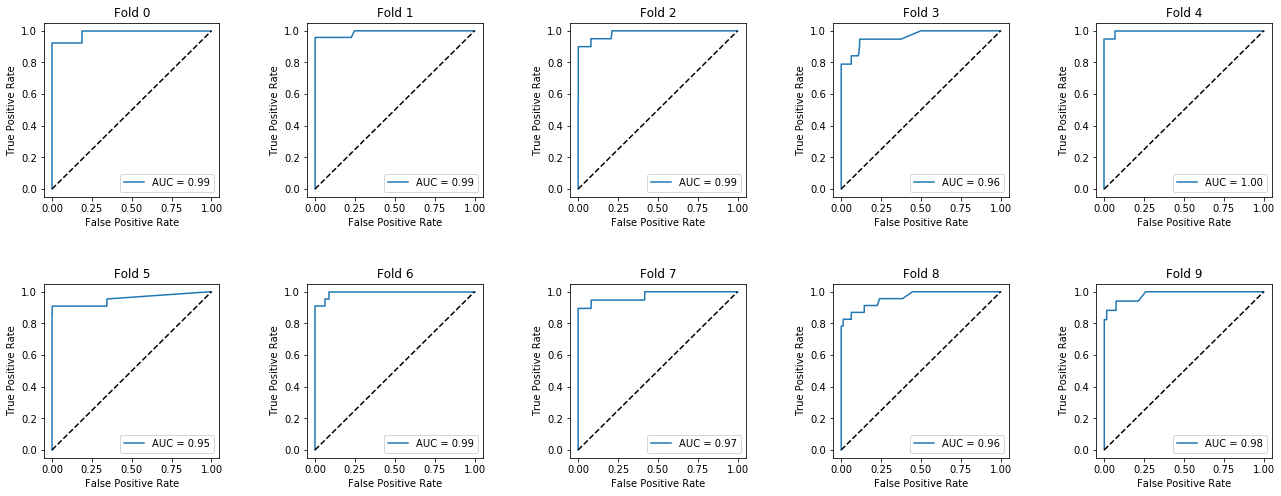

In [ ]:
# Receiver Operating Characteristic
fig, ax = plt.subplots(2,5, figsize=(22,8))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for fold, val in roc_probs.items():
    # suplot indices
    if fold < 5:
        row = 0
        col = fold
    else:
        row = 1
        col = fold - 5
    
    fpr, tpr, thresholds = roc_curve(roc_true[fold], val[:,1])
    roc_auc = auc(fpr, tpr)

    ax[row,col].plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
    ax[row,col].plot([0, 1], [0, 1], 'k--')
    ax[row,col].set_xlabel('False Positive Rate')
    ax[row,col].set_ylabel('True Positive Rate')
    ax[row,col].set_title('Fold {}'.format(fold))
    ax[row,col].legend(loc="lower right")

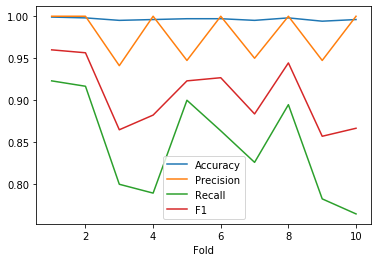

In [ ]:
# Plot results
x_val = np.arange(1, k+1)

plt.plot(x_val, accuracies)
plt.plot(x_val, precisions)
plt.plot(x_val, recalls)
plt.plot(x_val, f1_scores)
plt.xlabel('Fold')
plt.legend(['Accuracy', 'Precision', 'Recall', 'F1'])
plt.show()

In [ ]:
print('Mean Accuracy = {}'.format(np.mean(accuracies)))
print('Mean Precision = {}'.format(np.mean(precisions)))
print('Mean Recall = {}'.format(np.mean(recalls)))
print('Mean F1 = {}'.format(np.mean(f1_scores)))

Mean Accuracy = 0.9965653562700842
Mean Precision = 0.9785913312693498
Mean Recall = 0.8460992014222597
Mean F1 = 0.9065620635027903


This looks good! But **why is there a big discrepancy between recall and accuracy**? Let's go back and have a closer look at the data. Specifically, we want to get more insight into the data distribution. As an example, let's plot the first and second feature...

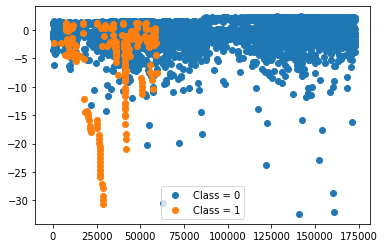

In [ ]:
# Scatter plot of the first to variables
for c in np.unique(y_train):
  plt.scatter(X_train[y_train==c,0], X_train[y_train==c,1], label='Class = {}'.format(c))

plt.legend()
plt.show()

In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([8989,  183]))

Apparently, the credit **data set is highly imbalanced**. What can we do differently to get a better recall?

* **Resampling**: Sample data set in a way that balances the amount of instances per class. Either generate new samples for the low-frequency class (Oversampling) or remove samples from the high-frequency class (Undersampling)
![Resampling](https://miro.medium.com/max/1450/0*FeIp1t4uEcW5LmSM.png) 
* **Weighting classes**: Some predictive models allow you to specify class weights. This way, we can weight classes according to their frequency or importance during training.
* **Different Predictive Model**: Some predictive models work well for imbalanced data (e.g. Gradient Boosted Trees)
* **Collect more data**: Not always feasible, yet the best option.

One more thing we did not do properly: **Tuning the model hyperparameters**
Hyperparameters cannot be learned by the model during training and thus need to be specified by the user (as opossed to model parameters). Finding the hyperparameters that optimize our objective can be time-comsuming, e.g. we can test different hyperparameters with Cross Validation and Grid Search. 

### Take Aways

*  Get to know your data properly! Are there any outliers, missing values, imbalances, high-dimensionalities?
*  Evalute your model with (stratified) K-fold cross validation
*  Tune your hyperparameters on a separate validation set or via cross validation
*  Consider your choice of evaluation metric carefully! Whether a metric is appropriate depends on the data and your application. Be particularly careful with the Accuracy, as it is biased towards imbalanced data.
